<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install --upgrade tensorflow

In [4]:
pip install keras==2.4.3


  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.4.3 which is incompatible.


In [5]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/LCL-June2015v2_134.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005555,Std,2012-06-15 03:30:00.0000000,0.118
1,MAC005555,Std,2012-06-15 04:00:00.0000000,0.078
2,MAC005555,Std,2012-06-15 04:30:00.0000000,0.091
3,MAC005555,Std,2012-06-15 05:00:00.0000000,0.068
4,MAC005555,Std,2012-06-15 05:30:00.0000000,0.092
5,MAC005555,Std,2012-06-15 06:00:00.0000000,0.194
6,MAC005555,Std,2012-06-15 06:30:00.0000000,0.091
7,MAC005555,Std,2012-06-15 07:00:00.0000000,0.069
8,MAC005555,Std,2012-06-15 07:30:00.0000000,0.088
9,MAC005555,Std,2012-06-15 08:00:00.0000000,0.087


In [8]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [9]:
#Looking for columns' datatypes
print(f"full_df columns datatypes: {full_df.dtypes} \n")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object 



In [10]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])

# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time


# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC005555      Std 2012-06-15 03:30:00                  0.118   2012-06-15   
1  MAC005555      Std 2012-06-15 04:00:00                  0.078   2012-06-15   
2  MAC005555      Std 2012-06-15 04:30:00                  0.091   2012-06-15   
3  MAC005555      Std 2012-06-15 05:00:00                  0.068   2012-06-15   
4  MAC005555      Std 2012-06-15 05:30:00                  0.092   2012-06-15   

       Time  
0  03:30:00  
1  04:00:00  
2  04:30:00  
3  05:00:00  
4  05:30:00  


In [11]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'DateTime', 'KWH/hh (per half hour) ', 'Date',
       'Time'],
      dtype='object')

In [12]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['Date', 'stdorToU', 'LCLid']).agg({'KWH/hh (per half hour) ': 'mean'}).reset_index()
full_df_daily.head(20)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [13]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['Date', 'stdorToU', 'LCLid', 'KWH/hh (per half hour) '] 

full_df_daily shape: (20876, 4) 

full_df_daily columns datatypes: Date                        object
stdorToU                    object
LCLid                       object
KWH/hh (per half hour)     float64
dtype: object 

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     5
dtype: int64 



In [14]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['KWH/hh (per half hour) '].isnull()].index
print(nan_indices)

Index([9038, 9039, 9040, 9041, 9044], dtype='int64')


In [15]:
#Dealing with nan values
full_df_daily['KWH/hh (per half hour) '].fillna(full_df_daily['KWH/hh (per half hour) '].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [16]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     0
dtype: int64 



In [17]:
##Descriptive Statistics
full_df_daily.describe()

,KWH/hh (per half hour)
count,20876.000000
mean,0.217520
std,0.139705
min,0.000000
25%,0.112432
50%,0.179531
75%,0.291630
max,1.391292


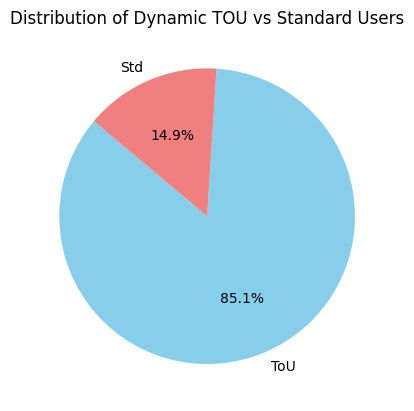

In [18]:
# Count the occurrences of each category
counts = full_df_daily['stdorToU'].value_counts()

# Plot a pie chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Dynamic TOU vs Standard Users')
plt.show()


            Date stdorToU      LCLid  KWH/hh (per half hour) 
3005  2012-04-24      Std  MAC005561                 0.208625
3028  2012-04-25      Std  MAC005561                 0.047000
3293  2012-05-07      Std  MAC005562                 0.192149
3316  2012-05-08      Std  MAC005562                 0.169229
3339  2012-05-09      Std  MAC005562                 0.137375
         Date stdorToU      LCLid  KWH/hh (per half hour) 
0  2011-11-23      ToU  MAC000146                 0.187300
1  2011-11-24      ToU  MAC000146                 0.178417
2  2011-11-25      ToU  MAC000146                 0.140479
3  2011-11-26      ToU  MAC000146                 0.125604
4  2011-11-27      ToU  MAC000146                 0.119583


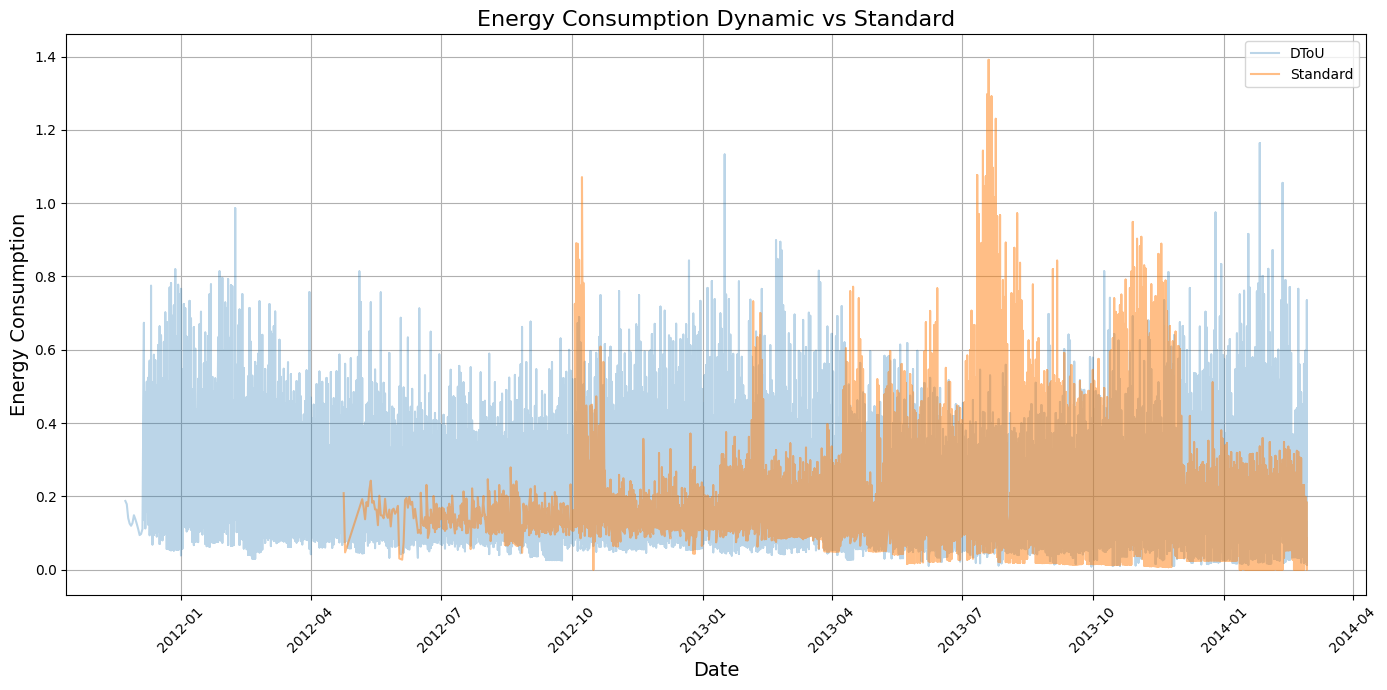

In [19]:
# Filter for dynamic and standard pricing
df_standard = full_df_daily[full_df_daily['stdorToU'] == 'Std']
df_dynamic = full_df_daily[full_df_daily['stdorToU'] == 'ToU']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
#plt.hist(df_dynamic['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'b', label='Dynamic')
#plt.hist(df_standard['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'r', label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['KWH/hh (per half hour) '], alpha = 0.3, label='DToU')
plt.plot(df_standard['Date'], df_standard['KWH/hh (per half hour) '],alpha = 0.5, label='Standard')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
quantile1 = full_df_daily['KWH/hh (per half hour) '].quantile(0.25)
quantile3 = full_df_daily['KWH/hh (per half hour) '].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [21]:
full_df_daily['log_KWH'] = np.log(full_df_daily['KWH/hh (per half hour) '])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


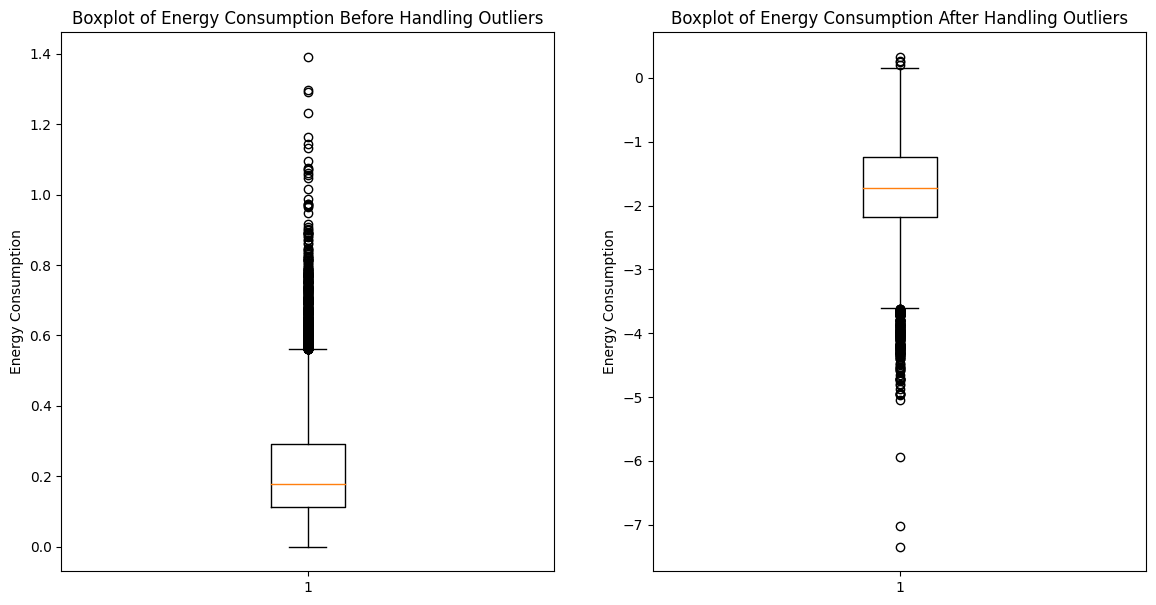

In [22]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
plt.boxplot(full_df_daily['KWH/hh (per half hour) '])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')

plt.subplot(1,2,2)
plt.boxplot(full_df_daily['log_KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.show()

In [23]:
def preprocess_data(df, time_step):
    data = df['KWH/hh (per half hour) '].values
    dates = df['Date'].values  # Using 'Date' column
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y, datestamps = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
        datestamps.append(dates[i + time_step])  # Store corresponding date
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    datestamps = np.array(datestamps)  # Convert list to numpy array
    return X, y, scaler, datestamps


In [24]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic, date_stamps_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard, date_stamps_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [25]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [26]:
# Train the LSTM model for dynamic users
model_dynamic = build_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)


Building LSTM model with input shape: (8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0156 - val_loss: 0.0139
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0134 - val_loss: 0.0139
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0122 - val_loss: 0.0126
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0119 - val_loss: 0.0124
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0112 - val_loss: 0.0122
Epoch 11/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0116 - val_loss: 0.0121
Epoch 12/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/s

In [27]:
# Train the LSTM model for standard users
model_standard = build_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_standard = model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)


Building LSTM model with input shape: (8, 1)
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0189 - val_loss: 0.0116
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0067
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 12/20
78/78 ━━━━━━━━━━

In [28]:
# Predict consumption for dynamic users
pred_dynamic = model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard = model_standard.predict(X_test_std)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [29]:
# Inverse transform the predictions for dynamic users
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [30]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
peak_dynamic_time = y_test_dyn_inverse[np.argmax(pred_dynamic)]

# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
peak_standard_time = y_test_std_inverse[np.argmax(pred_standard)]


In [31]:
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
print(f"Corresponding Actual Dynamic TOU Consumption Value: {peak_dynamic_time}")

print(f"Peak Standard TOU Consumption Value: {peak_standard_value}")
print(f"Corresponding Actual Standard TOU Consumption Value: {peak_standard_time}")


Peak Dynamic TOU Consumption Value: [0.5033679]
Corresponding Actual Dynamic TOU Consumption Value: [0.4238125]
Peak Standard TOU Consumption Value: [0.9200878]
Corresponding Actual Standard TOU Consumption Value: [1.04639583]


In [32]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 0.07966227871202053
Standard TOU MAE: 0.058205290388086535


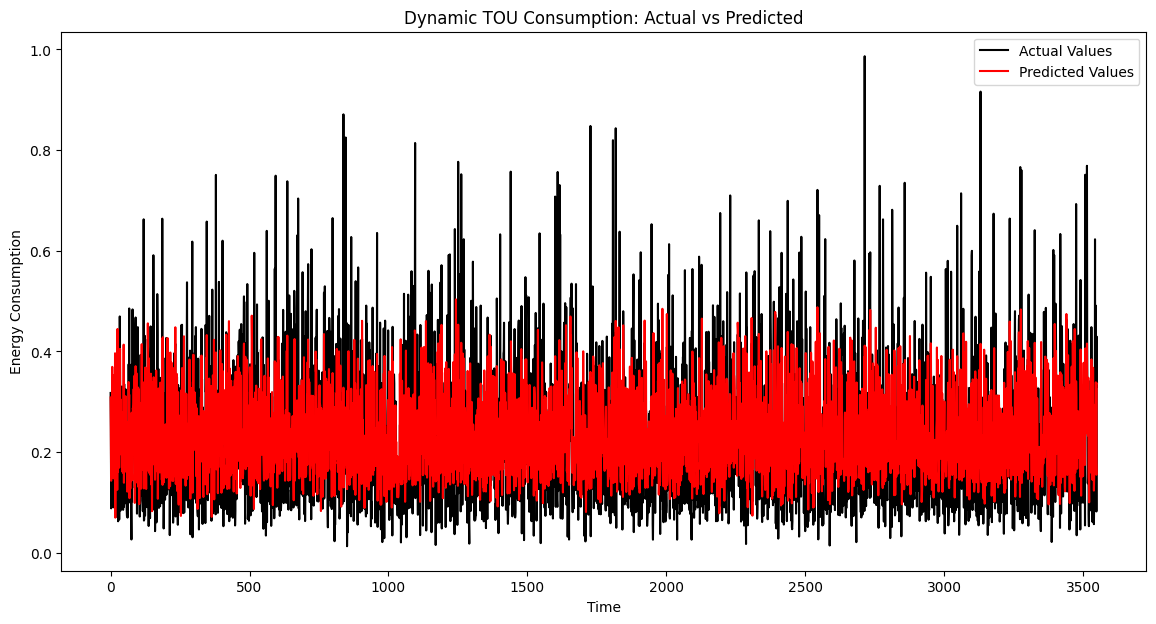

In [35]:

# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()




In [33]:
 !pip install keras==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.14.0 which is incompatible.


ModuleNotFoundError: No module named 'scikeras'